In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Function to load data and print data types
def load_data(file_path):
    """
    Load data from the specified file path and handle data types.
    """
    data = pd.read_excel(file_path)
    
    # Convert columns to appropriate data types
    # List of columns that should be numeric
    numeric_columns = ['current_size', 'fire_location_latitude', 'fire_location_longitude',
                       'discovered_size', 'assessment_hectares', 'fire_spread_rate',
                       'temperature', 'relative_humidity', 'wind_speed', 'distance_from_water_source',
                       'bh_hectares', 'uc_hectares', 'to_hectares', 'ex_hectares']

    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, set errors to NaN
    
    # Print data types of all columns
    print(data.dtypes)
    
    return data

def main(file_path):
    """
    Main function to load data and print data types.
    """
    data = load_data(file_path)
    return data

if __name__ == "__main__":
    # Ensure the file path is correctly formatted for your OS
    file_path = r"https://open.alberta.ca/dataset/a221e7a0-4f46-4be7-9c5a-e29de9a3447e/resource/80480824-0c50-456c-9723-f9d4fc136141/download/fp-historical-wildfire-data-2006-2023.xlsx"
    main(file_path)



fire_year                         int64
fire_number                      object
fire_name                        object
current_size                    float64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
industry_identifier_desc         object
responsible_group_desc           object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
discovered_size                 float64
reported_date                    object
dispatched_resource              object
dispatch_date                    object
start_for_fire_date              object
assessment_resource              object
assessment_datetime              object
assessment_hectares             float64


In [6]:
data = load_data(file_path)


fire_year                         int64
fire_number                      object
fire_name                        object
current_size                    float64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
industry_identifier_desc         object
responsible_group_desc           object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
discovered_size                 float64
reported_date                    object
dispatched_resource              object
dispatch_date                    object
start_for_fire_date              object
assessment_resource              object
assessment_datetime              object
assessment_hectares             float64


If we drop all na values, we end up with no data. So I will start by dropping columns with high missing values percentage.

In [7]:
# Convert date columns to datetime
date_columns = ['fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 'dispatch_date', 'assessment_datetime','ia_arrival_at_fire_date', 'fire_fighting_start_size', 'first_bucket_drop_date', 'bh_fs_date', 'uc_fs_date', 'to_fs_date', 'ex_fs_date']

# Convert each column to datetime
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [8]:
# Create a function to calculate fire_duration (in minutes)
def calculate_fire_duration(row):
    if pd.notnull(row['fire_start_date']):
        return (row['ex_fs_date'] - row['fire_start_date']).total_seconds() / 60
    elif pd.notnull(row['discovered_date']):
        return (row['ex_fs_date'] - row['discovered_date']).total_seconds() / 60
    elif pd.notnull(row['reported_date']):
        return (row['ex_fs_date'] - row['reported_date']).total_seconds() / 60
    else:
        return pd.NaT

# Apply the function row-wise to calculate fire_duration
data['fire_duration'] = data.apply(calculate_fire_duration, axis=1)

In [9]:
# Calculate the correlation between fire_duration and current_size
correlation_value = data['fire_duration'].corr(data['current_size'])

print(f"Correlation between fire_duration and current_size: {correlation_value}, indicating a weak positive linear relationship")

Correlation between fire_duration and current_size: 0.13294338799031138, indicating a weak positive linear relationship


In [10]:
# Create a location column
# Extracting the first letter into a new column 'location'
data['location'] = data['fire_number'].str[0]

# Mapping dictionary for location
location_map = {
    'C': 'Calgary',
    'E': 'Edson',
    'H': 'High Level',
    'G': 'Grande Prairie',
    'L': 'Lac La Biche',
    'M': 'Fort McMurray',
    'P': 'Peace River',
    'R': 'Rocky',
    'S': 'Slave Lake',
    'W': 'Whitecourt'
}

# Replace the values in 'location' column using the mapping dictionary
data['location'].replace(location_map, inplace=True)

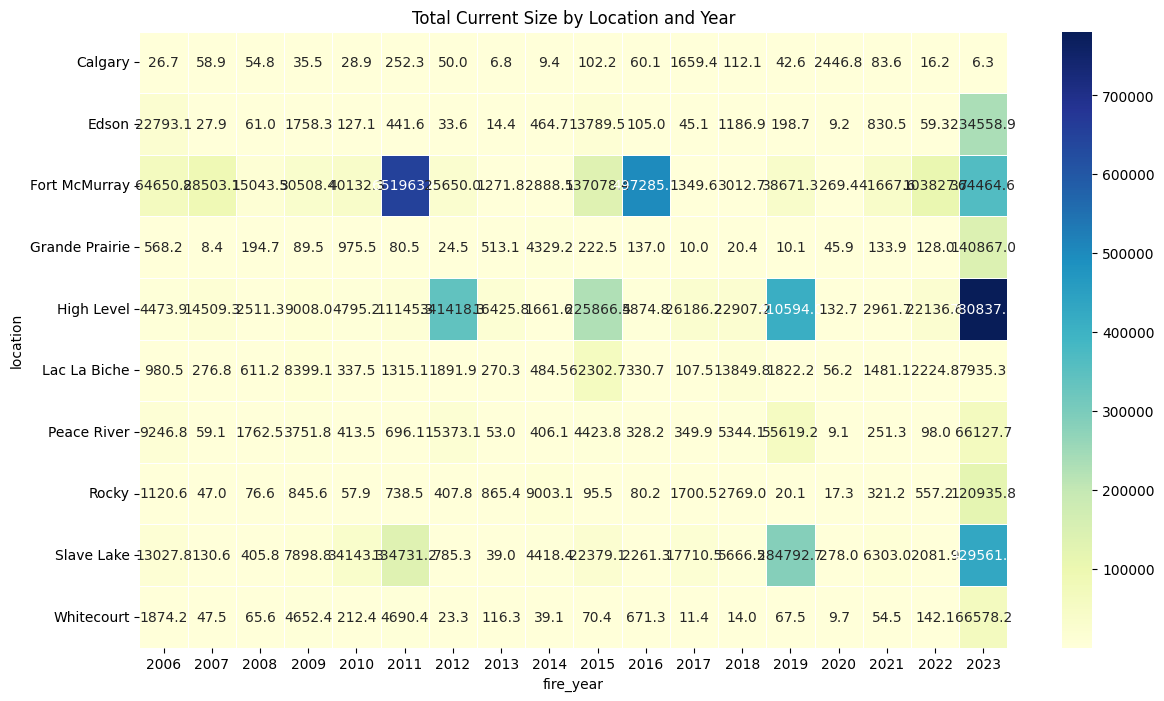

In [11]:
# Group by 'location' and 'fire_year' and calculate the total current_size
grouped_location_year = data.groupby(['location', 'fire_year']).agg({'current_size': 'sum'}).reset_index()

# Pivot the table to get years as columns and locations as rows
pivot_table = grouped_location_year.pivot(index='location', columns='fire_year', values='current_size')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Current Size by Location and Year')
plt.show()

Between 2006 and 2023, Fort McMurray, High Level, and Slave Lake experienced the highest amounts of area burned due to wildfires. In 2023, there was a noticeable increase in the size of areas burned across the majority of locations compared to previous years.

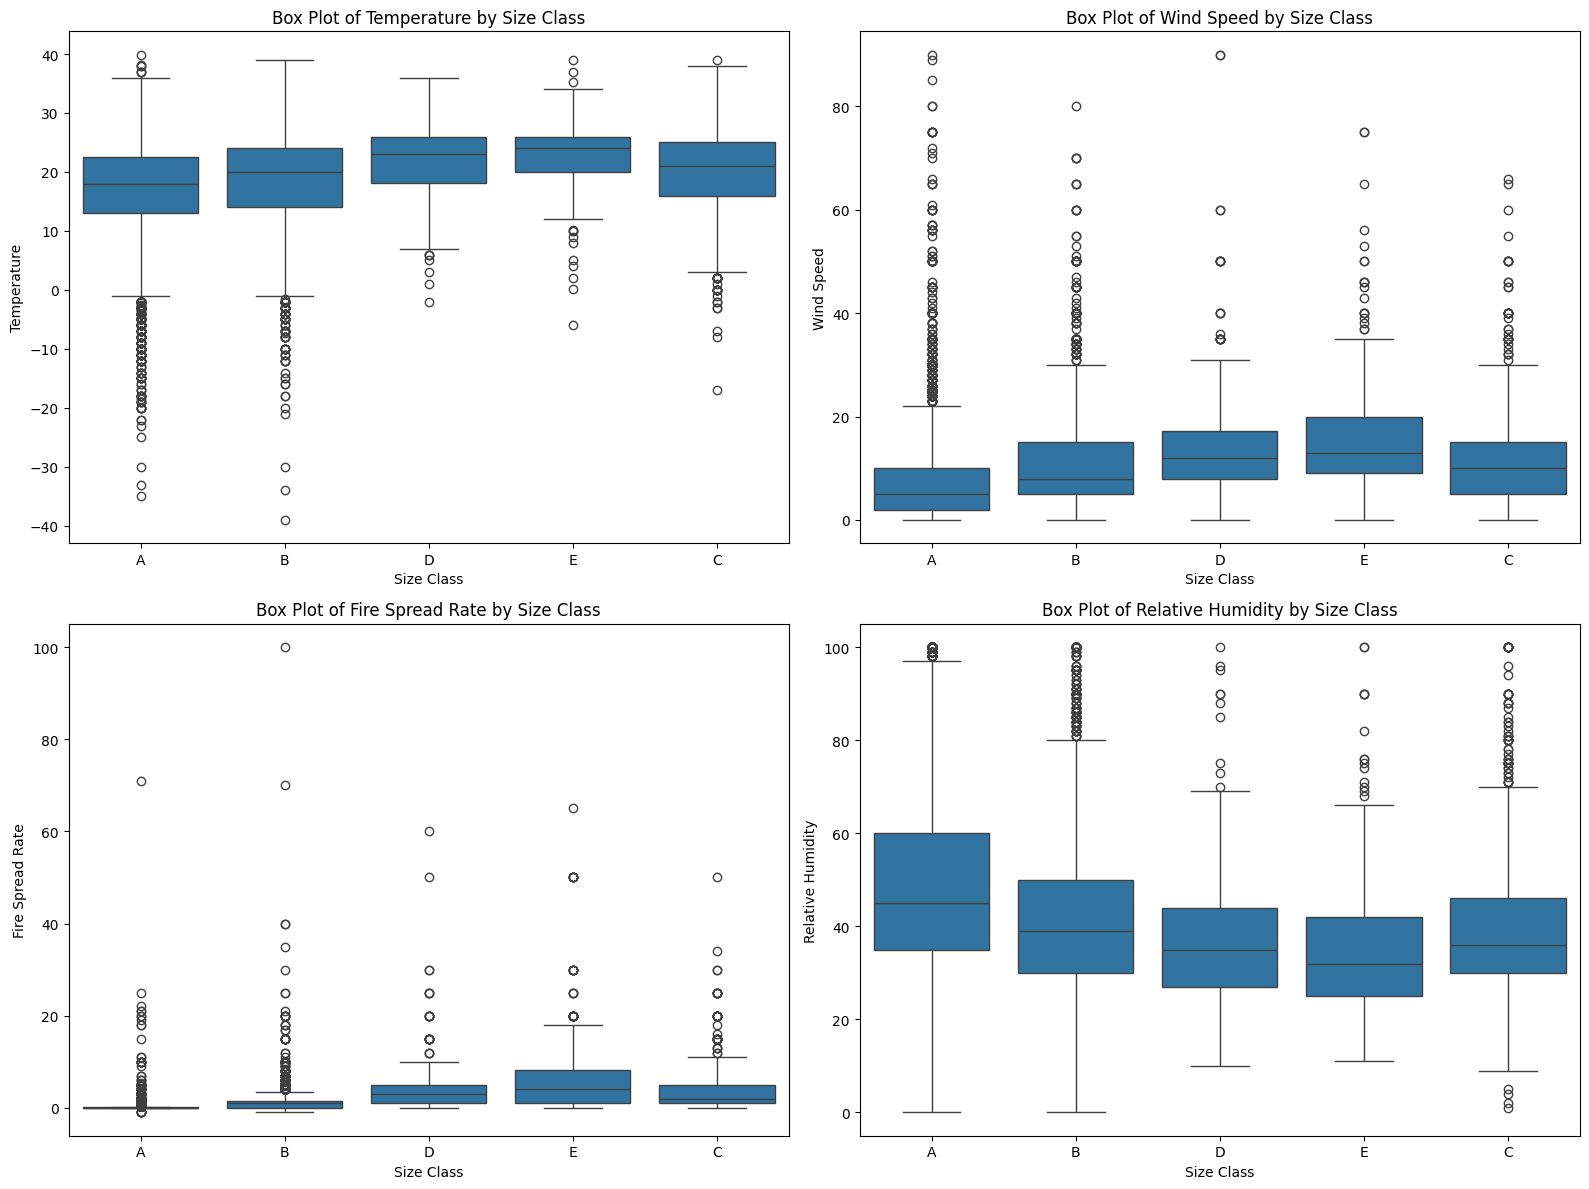

In [12]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create a box plot for temperature by size_class
sns.boxplot(x='size_class', y='temperature', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Temperature by Size Class')
axes[0, 0].set_xlabel('Size Class')
axes[0, 0].set_ylabel('Temperature')

# Create a box plot for wind_speed by size_class
sns.boxplot(x='size_class', y='wind_speed', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Wind Speed by Size Class')
axes[0, 1].set_xlabel('Size Class')
axes[0, 1].set_ylabel('Wind Speed')

# Create a box plot for fire_spread_rate by size_class
sns.boxplot(x='size_class', y='fire_spread_rate', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Box Plot of Fire Spread Rate by Size Class')
axes[1, 0].set_xlabel('Size Class')
axes[1, 0].set_ylabel('Fire Spread Rate')

# Create a box plot for relative_humidity by size_class
sns.boxplot(x='size_class', y='relative_humidity', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Relative Humidity by Size Class')
axes[1, 1].set_xlabel('Size Class')
axes[1, 1].set_ylabel('Relative Humidity')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Additionally, the data reveals a correlation between fire size class and environmental factors such as temperature, wind speed, and relative humidity. Specifically, larger fire size classes (Class E) are associated with higher temperatures, higher wind speeds, and lower humidity levels. However, there are some notable outliers:

Class A and B show variability in temperature and wind speed.
Class B and C display more outliers in terms of relative humidity.
Furthermore, as the fire size class increases, there is a corresponding increase in the fire spread rate. This indicates that larger fires tend to spread more rapidly, influenced by the more extreme environmental conditions they occur under.

Comparison of Total Current Size and Number of Fires by Year:
    fire_year  current_size  count
0        2006     118761.87   1954
1        2007     103668.54   1348
2        2008      20786.91   1712
3        2009      66947.44   1710
4        2010      81223.74   1840
5        2011     806054.64   1218
6        2012     385657.86   1568
7        2013      19575.84   1226
8        2014      23704.53   1470
9        2015     466330.48   1898
10       2016     507134.11   1376
11       2017      49130.33   1244
12       2018      54882.68   1279
13       2019     791838.41   1005
14       2020       3274.45    723
15       2021      54088.58   1342
16       2022     131271.77   1276
17       2023    2211873.23   1132


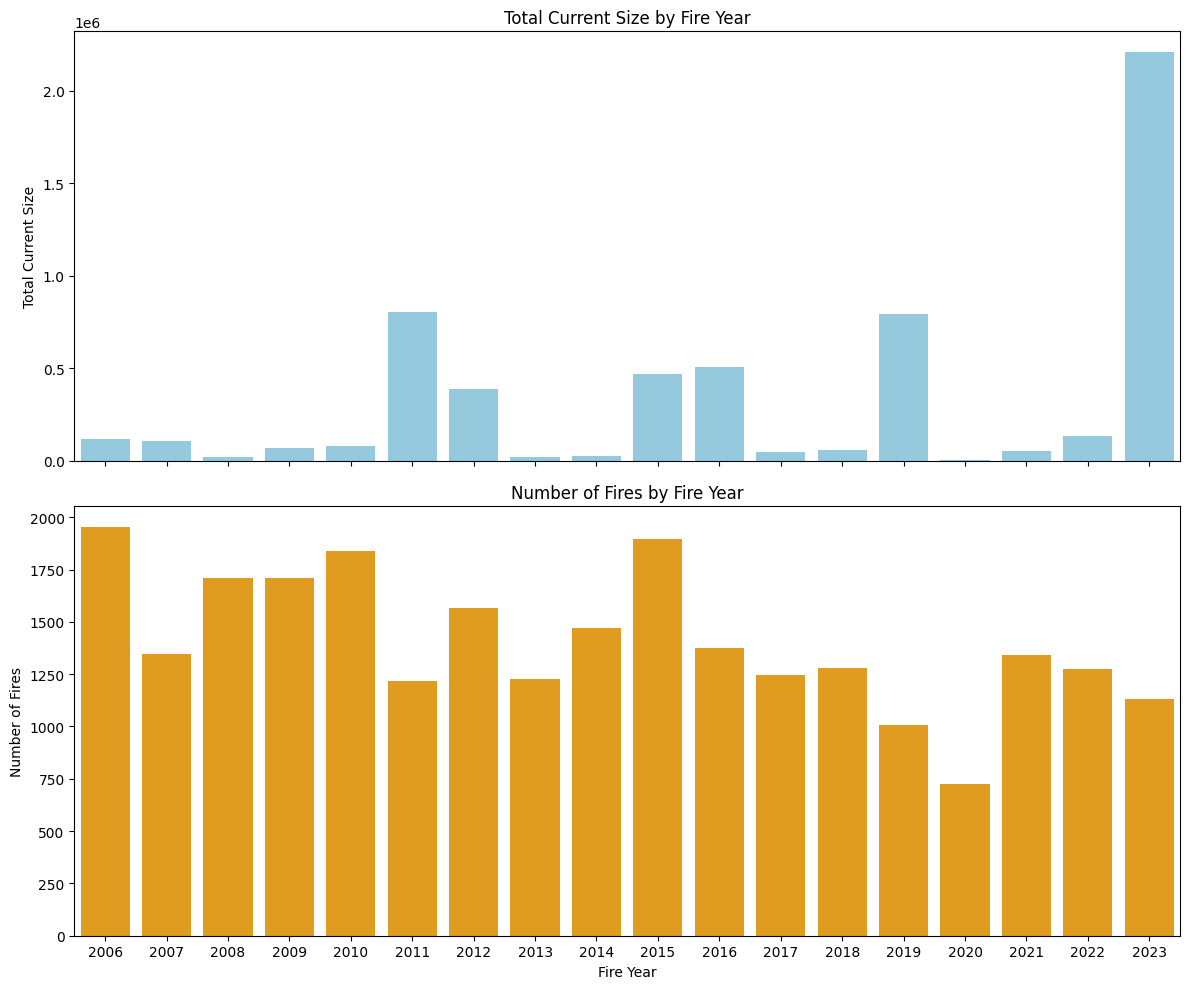

In [13]:
# Group by fire_year and calculate the mean current_size and count of items
grouped_df = data.groupby('fire_year').agg({'current_size': 'sum', 'size_class': 'count'}).reset_index()
grouped_df.rename(columns={'size_class': 'count'}, inplace=True)

# Convert fire_year to integer (ensure it's already integer in your original dataframe)
grouped_df['fire_year'] = grouped_df['fire_year'].astype(int)

# Display as a table
print("Comparison of Total Current Size and Number of Fires by Year:")
print(grouped_df)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Bar plot for Total Current Size
sns.barplot(data=grouped_df, x='fire_year', y='current_size', ax=ax1, color='skyblue')
ax1.set_title('Total Current Size by Fire Year')
ax1.set_ylabel('Total Current Size')

# Bar plot for Number of Fires
sns.barplot(data=grouped_df, x='fire_year', y='count', ax=ax2, color='orange')
ax2.set_title('Number of Fires by Fire Year')
ax2.set_xlabel('Fire Year')
ax2.set_ylabel('Number of Fires')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

There was a substantial increase in the total area burned in 2023, which surpassed the previously high totals recorded in 2011 and 2019. Despite this increase in fire size, the number of fires has been on a decreasing trend over the past years. The number of fires reached its lowest point in 2020, with the second lowest in 2017. Interestingly, although the area burned in 2023 was the highest, the number of fires that year was the third lowest in recent history. This suggests that while fewer fires are occurring, they tend to be larger and more destructive.

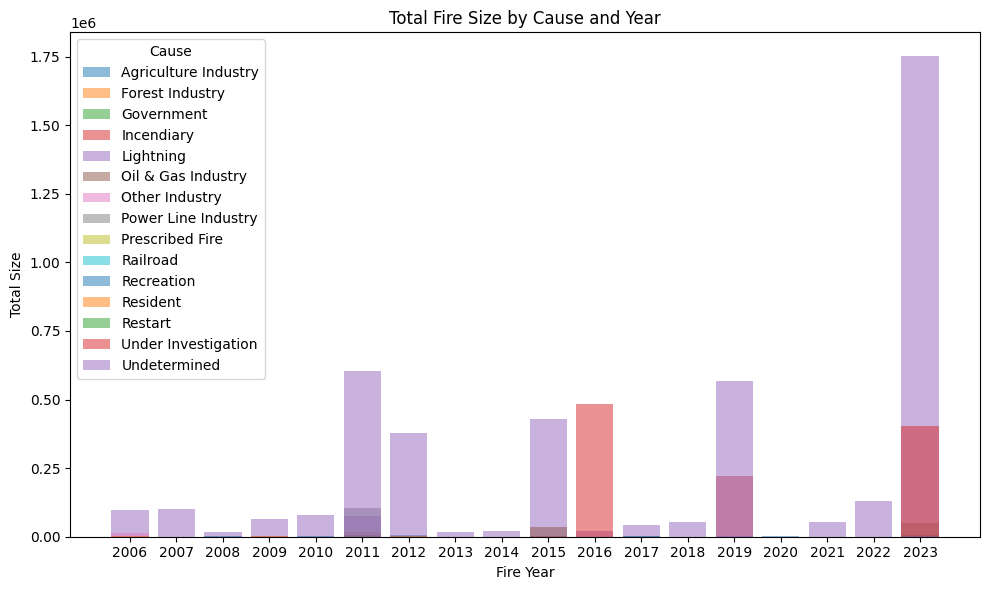

In [14]:
grouped_data = data.groupby(['general_cause_desc', 'fire_year'])['current_size'].sum().reset_index()

plt.figure(figsize=(10, 6)) 
# Iterate over unique general_cause_desc values for separate bars
for i, cause in enumerate(grouped_data['general_cause_desc'].unique()):
    plt.bar(
        grouped_data[grouped_data['general_cause_desc'] == cause]['fire_year'],
        grouped_data[grouped_data['general_cause_desc'] == cause]['current_size'],
        label=cause,
        alpha=0.5
    )

plt.xlabel('Fire Year')
plt.ylabel('Total Size')
plt.title('Total Fire Size by Cause and Year')
plt.xticks(grouped_data['fire_year'].unique())
plt.legend(title='Cause')

plt.tight_layout()
plt.show()


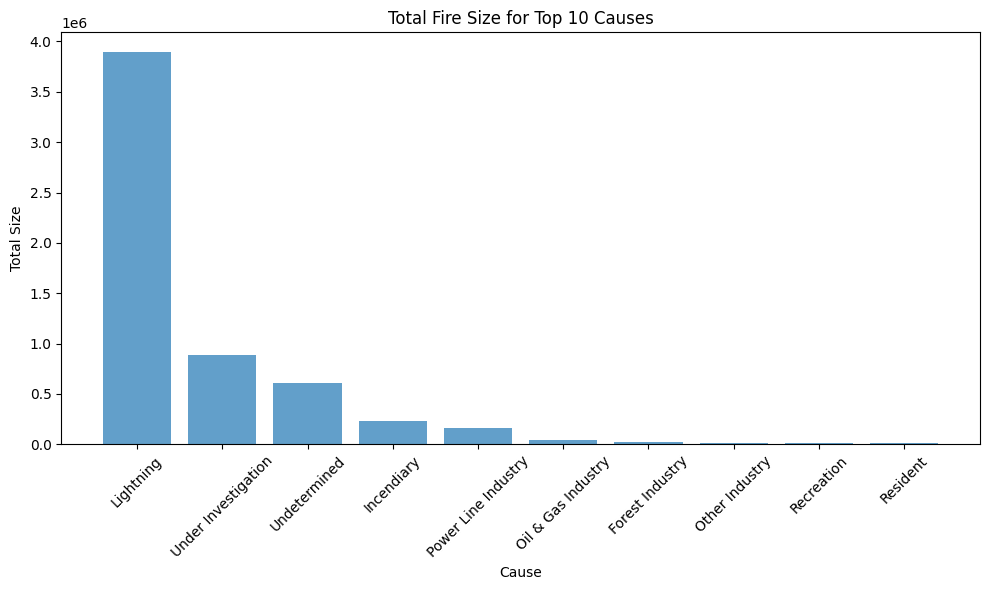

In [15]:
# Group by 'general_cause_desc' and sum the 'current_size' to get total size for each cause
total_size_by_cause = data.groupby('general_cause_desc')['current_size'].sum().reset_index()

# Identify the top 10 causes based on total size
top_5_causes = total_size_by_cause.nlargest(10, 'current_size')

# Plot the data for the top 10 causes
plt.figure(figsize=(10, 6))
plt.bar(top_5_causes['general_cause_desc'], top_5_causes['current_size'], alpha=0.7)

plt.xlabel('Cause')
plt.ylabel('Total Size')
plt.title('Total Fire Size for Top 10 Causes')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Basic Data Cleaning by Ray

In [16]:
data.shape

(25321, 52)

In [17]:
# Summary for missing values
# Adjusted code to display percentage of NA values for easier analysis

missing_summary = data.isna().sum()/len(data)*100

print("Summary of missing values for each column:")
print(missing_summary)

Summary of missing values for each column:
fire_year                        0.000000
fire_number                      0.000000
fire_name                       97.120967
current_size                     0.000000
size_class                       0.000000
fire_location_latitude           0.000000
fire_location_longitude          0.000000
fire_origin                      0.063189
general_cause_desc               0.000000
industry_identifier_desc        98.175428
responsible_group_desc          62.943802
activity_class                  38.596422
true_cause                      46.483156
fire_start_date                  2.689467
det_agent_type                   0.000000
det_agent                        0.000000
discovered_date                 19.513447
discovered_size                 99.423403
reported_date                    0.000000
dispatched_resource              0.067138
dispatch_date                    0.067138
start_for_fire_date              0.078986
assessment_resource              

In [18]:
# data.dropna()

In [19]:
columns_drop=[
'fire_year',                            # Redundant date column, the same information is available in the multiple other date columns. 
'fire_number',                          # useless column that is used as an indexing column
'fire_name',                            # 97.120967% missing values
'industry_identifier_desc',             # 98.175428% missing values
'true_cause',                           # 46.48% missing values
'ia_access',                            # 55.99% missing values
'activity_class',                       # 38.59% missing values
'discovered_size',                      # important column, but has 99% missing values
'responsible_group_desc',               # 62% missing values
'distance_from_water_source',           # 71.98% missing values
'first_bucket_drop_date',               # 71.97% missing values
'to_fs_date',                           # 89.55% missing values
'to_hectares'                           # 89.55% missing values
]
clean_na=data.drop(columns=columns_drop)

In [20]:
# Convert date columns to datetime
date_columns = ['fire_start_date', 
                'discovered_date', 
                'reported_date', 
                'start_for_fire_date', 
                'dispatch_date', 
                'assessment_datetime',
                'ia_arrival_at_fire_date', 
                'fire_fighting_start_size', 
                 'bh_fs_date', 
                 'uc_fs_date', 
                 'ex_fs_date']

# Convert each column to datetime
for col in date_columns:
    clean_na[col] = pd.to_datetime(clean_na[col], errors='coerce')

In [21]:
#Code column to binary for data analysis
clean_na['bucketing_on_fire']=clean_na['bucketing_on_fire'].map({'Y': 1, 'N': 0})

In [22]:
# droppping rows with NA values
clean_na.dropna(inplace=True)
clean_na.shape

(11045, 39)

In [23]:
clean_na.dtypes

current_size                           float64
size_class                              object
fire_location_latitude                 float64
fire_location_longitude                float64
fire_origin                             object
general_cause_desc                      object
fire_start_date                 datetime64[ns]
det_agent_type                          object
det_agent                               object
discovered_date                 datetime64[ns]
reported_date                   datetime64[ns]
dispatched_resource                     object
dispatch_date                   datetime64[ns]
start_for_fire_date             datetime64[ns]
assessment_resource                     object
assessment_datetime             datetime64[ns]
assessment_hectares                    float64
fire_spread_rate                       float64
fire_type                               object
fire_position_on_slope                  object
weather_conditions_over_fire            object
temperature  

## Classification - KNN

In [24]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [25]:
datetime_columns = clean_na.select_dtypes(include=['datetime64']).columns
for column in datetime_columns:
    clean_na[column + '_year'] = clean_na[column].dt.year
    clean_na[column + '_month'] = clean_na[column].dt.month
    clean_na[column + '_day'] = clean_na[column].dt.day
    clean_na[column + '_hour'] = clean_na[column].dt.hour
    clean_na = clean_na.drop(columns=[column])

In [26]:
label_encoders = {}
for column in clean_na.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    clean_na[column] = label_encoders[column].fit_transform(clean_na[column])

In [27]:
clean_na.dtypes

current_size               float64
size_class                   int32
fire_location_latitude     float64
fire_location_longitude    float64
fire_origin                  int32
                            ...   
uc_fs_date_hour              int32
ex_fs_date_year              int32
ex_fs_date_month             int32
ex_fs_date_day               int32
ex_fs_date_hour              int32
Length: 72, dtype: object

In [28]:
# Separate the features (X) and the target (y)
X = clean_na.drop(columns = ['size_class'])
y = clean_na['size_class']
y = LabelEncoder().fit_transform(y)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# To find the best k- value
# Define k- value range
param_grid = {'n_neighbors': range(1, 15)}

grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 12


In [30]:
#Using the best k -value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)

# Performance evluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.5540968764146673
Confusion Matrix:
[[855 252  14   8   4]
 [430 311  22   4   9]
 [ 58  96  18   2   7]
 [ 15  12  10   3   6]
 [ 17   8   4   7  37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      1133
           1       0.46      0.40      0.43       776
           2       0.26      0.10      0.14       181
           3       0.12      0.07      0.09        46
           4       0.59      0.51      0.54        73

    accuracy                           0.55      2209
   macro avg       0.41      0.37      0.38      2209
weighted avg       0.52      0.55      0.53      2209



Improvement

In [31]:
from sklearn.preprocessing import StandardScaler


In [32]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# To find the best k- value
# Define k- value range
param_grid = {'n_neighbors': range(1, 15)}

grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 13


In [34]:
#Using the best k -value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)

# Performance evluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.5980081484834767
Confusion Matrix:
[[952 180   1   0   0]
 [432 339   4   1   0]
 [ 47 123  11   0   0]
 [ 13  29   4   0   0]
 [ 12  29   8   5  19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.84      0.74      1133
           1       0.48      0.44      0.46       776
           2       0.39      0.06      0.11       181
           3       0.00      0.00      0.00        46
           4       1.00      0.26      0.41        73

    accuracy                           0.60      2209
   macro avg       0.51      0.32      0.34      2209
weighted avg       0.57      0.60      0.56      2209



Time Series Analysis

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [57]:
ts_data = clean_na.copy()

ts_data['fire_start_date'] = pd.to_datetime(
    ts_data[['start_for_fire_date_year', 'start_for_fire_date_month', 'start_for_fire_date_day', 'start_for_fire_date_hour']]
    .rename(columns={
        'start_for_fire_date_year': 'year',
        'start_for_fire_date_month': 'month',
        'start_for_fire_date_day': 'day',
        'start_for_fire_date_hour': 'hour'
    })
)

ts_data = ts_data[['current_size']].copy()

display(ts_data)

,current_size
fire_start_date,
2006-04-04 16:00:00,0.60
2006-07-03 13:00:00,0.01
2006-07-22 17:00:00,0.01
2006-07-30 12:00:00,0.05
2006-07-04 16:00:00,65.00
...,...
2023-07-31 16:00:00,0.20
2023-07-31 16:00:00,0.20
2023-06-28 15:00:00,0.02


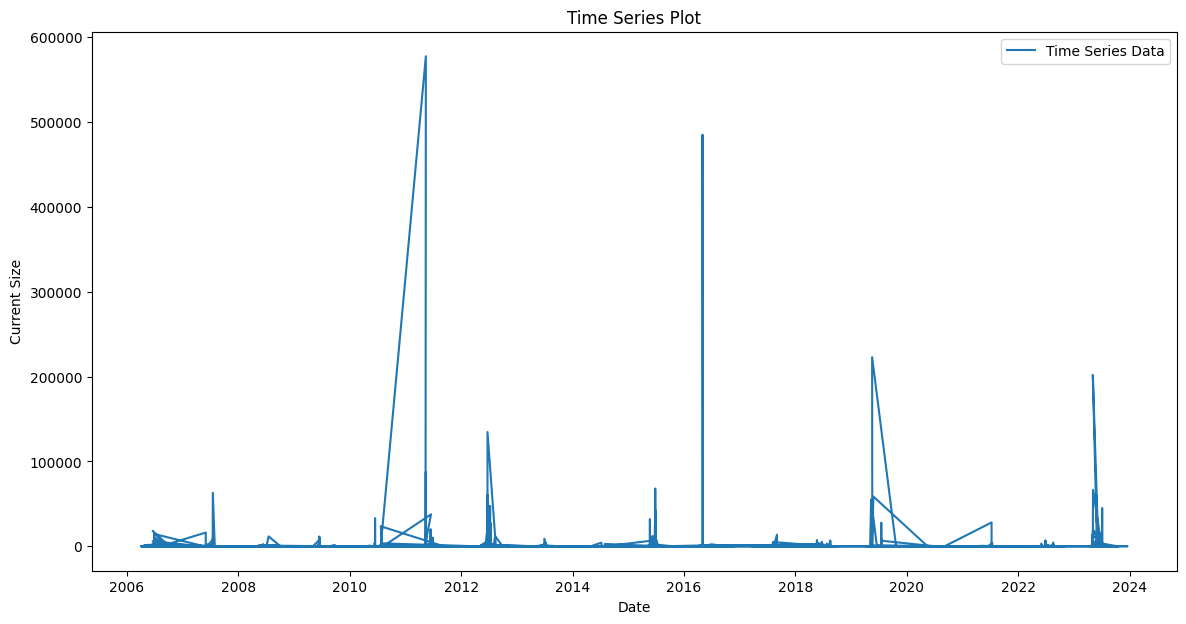

In [58]:
# Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data['current_size'], label='Time Series Data')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Current Size')
plt.legend()
plt.show()

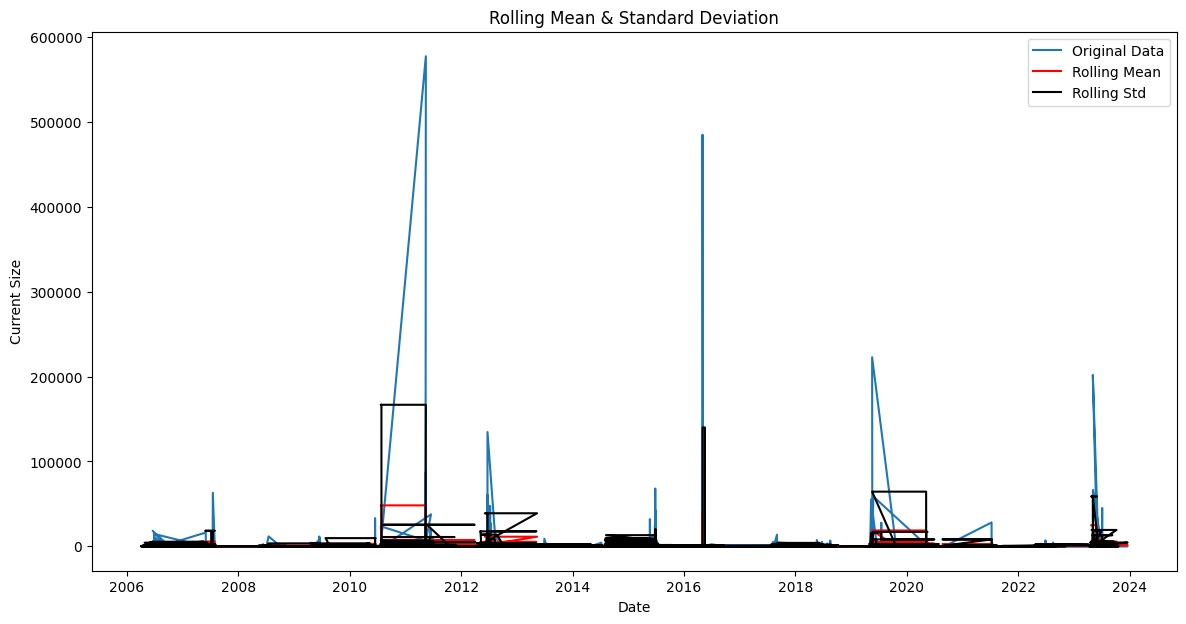

In [59]:
# Plot a Rolling Mean and Standard Deviation
rolling_mean = ts_data['current_size'].rolling(window=12).mean()
rolling_std = ts_data['current_size'].rolling(window=12).std()

plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data['current_size'], label='Original Data')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Current Size')
plt.legend()
plt.show()

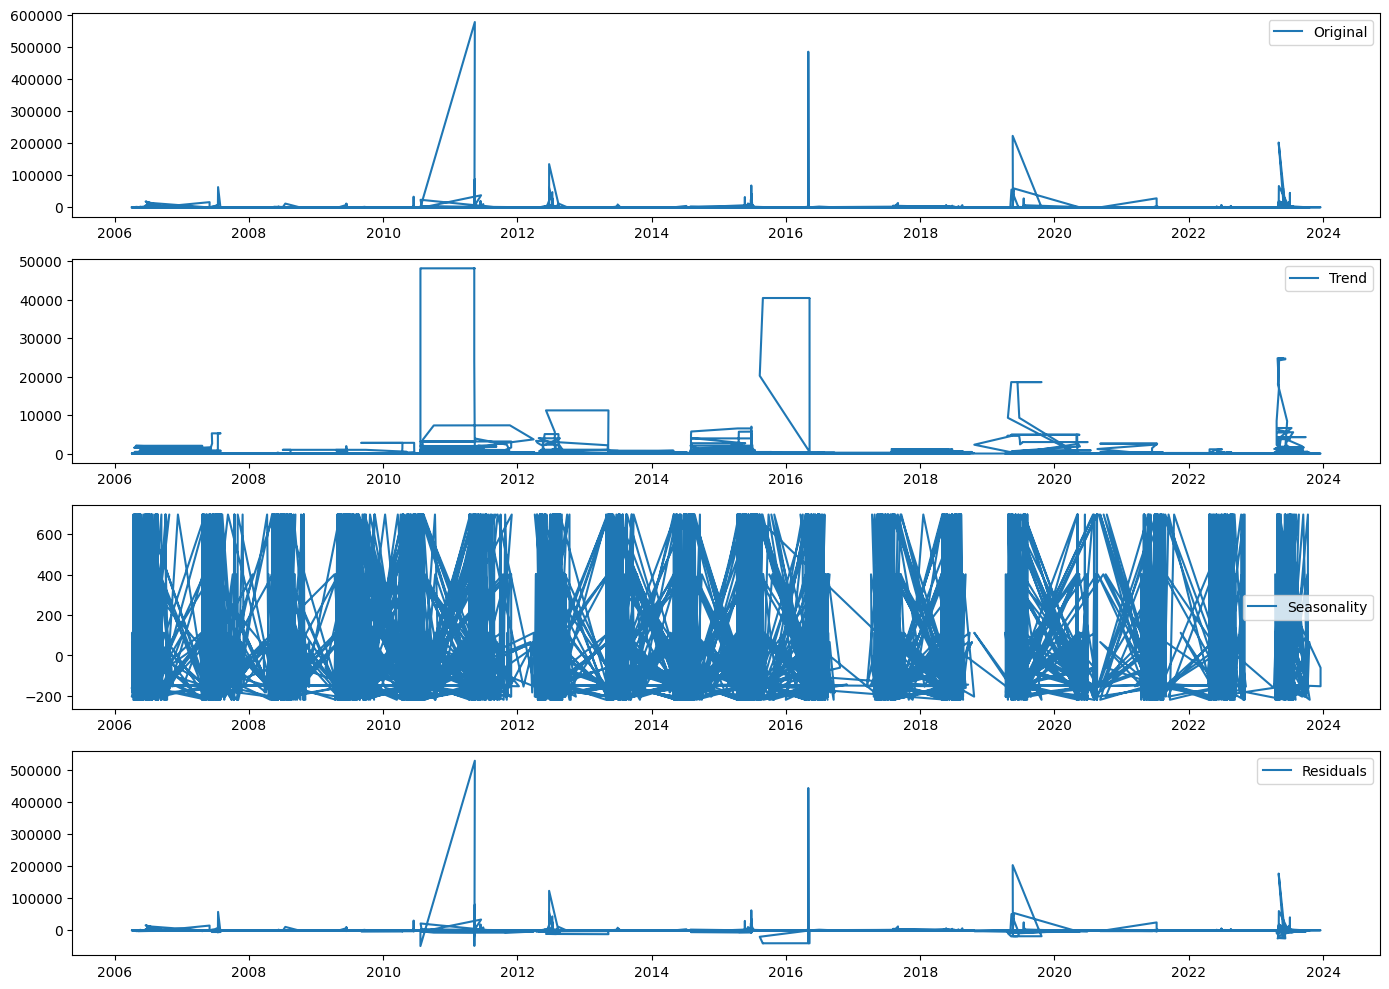

In [61]:
# Decompose the Time Series
decomposition = seasonal_decompose(ts_data['current_size'], model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(ts_data['current_size'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [62]:
# Check for stationary
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(ts_data['current_size'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')


ADF Statistic: -72.68809666960489
p-value: 0.0
Critical Values:
   1%, -3.4309423046915986
Critical Values:
   5%, -2.8618017661630577
Critical Values:
   10%, -2.5669093330045536
